### Loading the libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math

import NeuralNet as NN

c:\Users\aadip\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\aadip\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\aadip\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

### Loading data

In [2]:
LABEL_MAP = {
    0: 'Zero',
    1: 'One',
    2: 'Two',
    3: 'Three',
    4: 'Four',
    5: 'Five',
    6: 'Six',
    7: 'Seven',
    8: 'Eight',
    9: 'Nine',
}

M = 784 # number of pixels (features)
C = len(LABEL_MAP.keys())

In [3]:
# Load the MNIST dataset (handwritten digits)
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


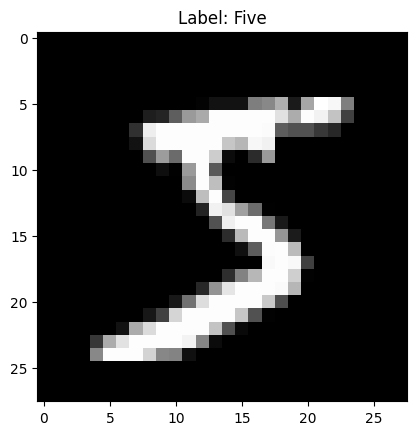

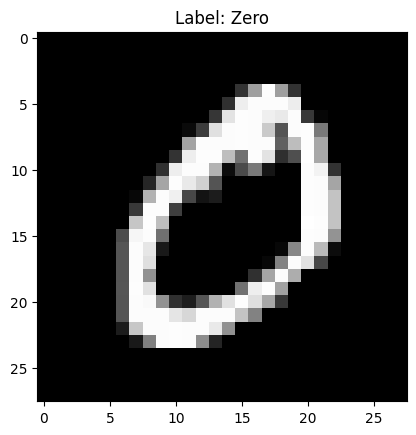

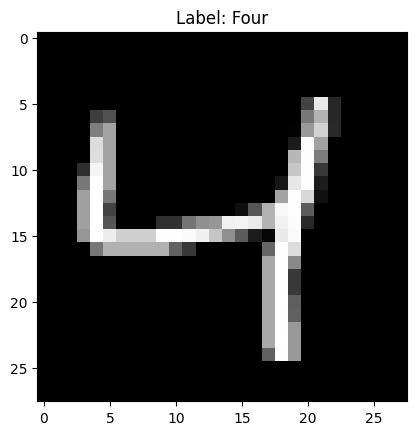

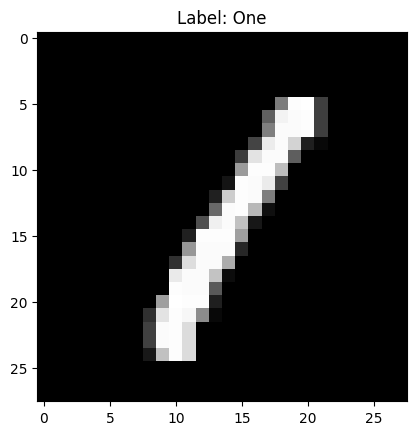

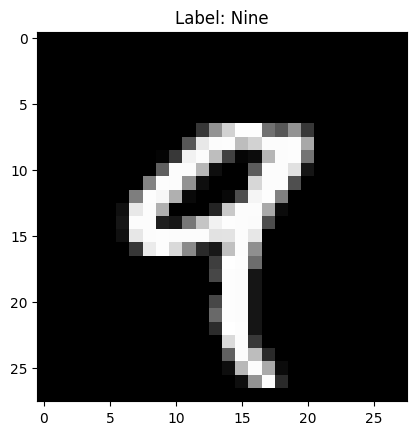

In [4]:
for i in range(5):
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {LABEL_MAP[int(Y_train[i])]}")
    plt.show()

In [5]:
# Save the train and test data as .npz files
np.savez_compressed('data/mnist_train.npz', X_train=X_train, Y_train=Y_train)
np.savez_compressed('data/mnist_test.npz', X_test=X_test, Y_test=Y_test)

In [6]:
NUM_TRAIN = 50000
NUM_VAL = 10000

data_train = np.load('data/mnist_train.npz')
data_test = np.load('data/mnist_test.npz')
X_train = data_train['X_train']
Y_train = data_train['Y_train']
X_test = data_test['X_test']
Y_test = data_test['Y_test']

# convert from (N, 28, 28) to (N, M), with M = 28*28 = 784
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

# convert from 1D array (N,) to 2D array (N, 1)
Y_train = Y_train.reshape((Y_train.shape[0], 1)) 
Y_test = Y_test.reshape((Y_test.shape[0], 1)) 

X_train, X_val = X_train[:NUM_TRAIN, :], X_train[NUM_TRAIN:, :]
Y_train, Y_val = Y_train[:NUM_TRAIN], Y_train[NUM_TRAIN:]

### Defining helper functions

In [7]:
def visualize_images(images, titles: list[str], color_map: list[str] = None, figsize: tuple[int, int] = (10, 10)):
    num_displays = len(images)
    num_cells = math.ceil(math.sqrt(num_displays))
    plt.figure(figsize=figsize)
    if color_map is None: color_map = ['Greys' for _ in range(num_displays)] 

    for i in range(num_displays):
        pixels = images[i]
        image_size = int(math.sqrt(pixels.shape[0]))
        frame = pixels.reshape((image_size, image_size))

        plt.subplot(num_cells, num_cells, i + 1)
        plt.imshow(frame, cmap=color_map[i])
        plt.title(titles[i])
        plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

In [8]:
def visualize_table(X: np.ndarray, Y: np.ndarray, num_display: int = 10):
    N, M = X.shape
    
    array = np.concatenate([Y, X], axis=1)

    header = ['pixel%d' % i for i in range(M)]
    header.insert(0, 'label') 
    
    df = pd.DataFrame(array, columns=header)
    df = df.set_index('label')

    df.head(num_display)
    
    return df

In [9]:
def onehot_encode(Y: np.ndarray, C: int):
    N = Y.shape[0] 
    Y = Y.flatten()
    onehot_Y = np.zeros((N, C))
    onehot_Y[np.arange(N), Y] = 1
    
    return onehot_Y

In [10]:
def plot_losses(num_epochs: list[int], train_losses: list[float], val_losses: list[float], fig_size=(6.4, 4.8)):
    plt.figure(figsize=fig_size) 

    plt.title('Average Negative Log Likelihood vs. Number of Epochs')
    plt.xlabel('Number of epochs')
    plt.ylabel('Average negative log likelihood')
    
    plt.plot(num_epochs, train_losses, label='training')
    plt.plot(num_epochs, val_losses, label='validation')
    
    plt.legend()
    plt.show()

### Visualizing input data

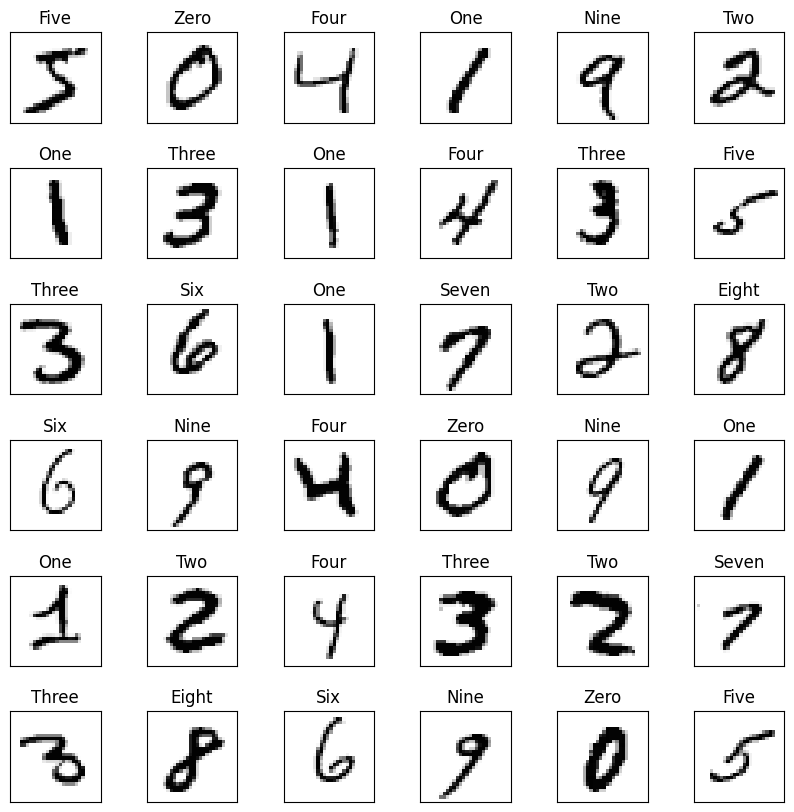

In [11]:
NUM_DISPLAY = 36
images = X_train[:NUM_DISPLAY, :]
titles = [LABEL_MAP[Y_train[i, 0]] for i in range(NUM_DISPLAY)]
visualize_images(images=images, titles=titles)

In [12]:
visualize_table(X=X_train, Y=Y_train, num_display=NUM_DISPLAY)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
MIN_VALUE = np.min(X_train)
MAX_VALUE = np.max(X_train)
X_train = np.float32(X_train / (MAX_VALUE - MIN_VALUE))
X_val = np.float32(X_val / (MAX_VALUE - MIN_VALUE))
X_test = np.float32(X_test / (MAX_VALUE - MIN_VALUE))

In [14]:
visualize_table(X=X_train, Y=Y_train, num_display=NUM_DISPLAY)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
onehot_Y_train = onehot_encode(Y=Y_train, C=C)
onehot_Y_val = onehot_encode(Y=Y_val, C=C)
onehot_Y_test = onehot_encode(Y=Y_test, C=C)

In [16]:
nnModel = NN.NeuralNetModel()

### Training

Single-layer Neural Network

Training your 1-layer neural net...
Epoch 0, train loss=0.5895, val loss=0.3113, duration=10.9012s
Epoch 0, train loss=0.5895, val loss=0.3113, duration=10.9012s
Epoch 1, train loss=0.3006, val loss=0.2558, duration=10.5265s
Epoch 1, train loss=0.3006, val loss=0.2558, duration=10.5265s
Epoch 2, train loss=0.2527, val loss=0.2234, duration=10.4009s
Epoch 2, train loss=0.2527, val loss=0.2234, duration=10.4009s
Epoch 3, train loss=0.2206, val loss=0.1999, duration=10.8371s
Epoch 3, train loss=0.2206, val loss=0.1999, duration=10.8371s
Epoch 4, train loss=0.1962, val loss=0.1821, duration=10.7777s
Epoch 4, train loss=0.1962, val loss=0.1821, duration=10.7777s
Epoch 5, train loss=0.1769, val loss=0.1682, duration=10.8100s
Epoch 5, train loss=0.1769, val loss=0.1682, duration=10.8100s
Epoch 6, train loss=0.1612, val loss=0.1572, duration=10.8749s
Epoch 6, train loss=0.1612, val loss=0.1572, duration=10.8749s
Epoch 7, train loss=0.1483, val loss=0.1481, duration=10.5490s
Epoch 7, train loss

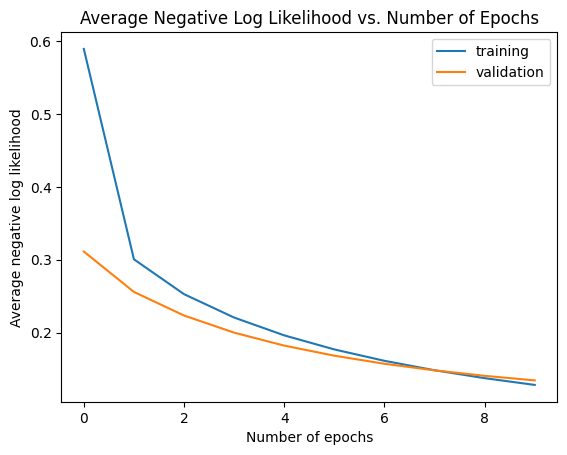

In [17]:
D1 = 64
W1 = np.random.uniform(high=-0.1, low=0.1, size=(D1, M+1))
W2 = np.random.uniform(high=-0.1, low=0.1, size=(C, D1+1))
num_epochs = 10
lr = 0.001

print('Training your 1-layer neural net...')
nn1layer_output = nnModel.trainSLNN(X_train=X_train, 
                                 Y_train=onehot_Y_train, 
                                 X_val=X_val, 
                                 Y_val=onehot_Y_val, 
                                 W1=W1, 
                                 W2=W2, 
                                 num_epochs=num_epochs, 
                                 lr=lr)

print('Plotting loss vs. epoch graphs...')
num_epochs_lst = [i for i in range(num_epochs)]
plot_losses(num_epochs=num_epochs_lst, 
            train_losses=nn1layer_output['train_losses'], 
            val_losses=nn1layer_output['val_losses'])

In [18]:
print('Making predictions...')
Y_hat_train = nnModel.predictSingle(X_train, nn1layer_output['best_W1'], nn1layer_output['best_W2'])
Y_hat_val = nnModel.predictSingle(X_val, nn1layer_output['best_W1'], nn1layer_output['best_W2'])
Y_hat_test = nnModel.predictSingle(X_test, nn1layer_output['best_W1'], nn1layer_output['best_W2'])

print('Getting accuracies...')
train_accuracy = 1 - NN.CoreFunctions.errorRate(Y_train, Y_hat_train['labels'])
val_accuracy = 1 - NN.CoreFunctions.errorRate(Y_val, Y_hat_val['labels'])
test_accuracy = 1 - NN.CoreFunctions.errorRate(Y_test, Y_hat_test['labels'])

print('accuracy on train = %0.2f %%' % (100*train_accuracy))
print('accuracy on val = %0.2f %%' % (100*val_accuracy))
print('accuracy on test = %0.2f %%' % (100*test_accuracy))

Making predictions...
Getting accuracies...
accuracy on train = 96.64 %
accuracy on val = 96.17 %
accuracy on test = 96.00 %
Getting accuracies...
accuracy on train = 96.64 %
accuracy on val = 96.17 %
accuracy on test = 96.00 %


Double-layer Neural Network

Training your 2-layer neural net...
Epoch 0, train loss=0.7758, val loss=0.3282, duration=12.4828s
Epoch 0, train loss=0.7758, val loss=0.3282, duration=12.4828s
Epoch 1, train loss=0.2988, val loss=0.2490, duration=11.7888s
Epoch 1, train loss=0.2988, val loss=0.2490, duration=11.7888s
Epoch 2, train loss=0.2312, val loss=0.2017, duration=12.5973s
Epoch 2, train loss=0.2312, val loss=0.2017, duration=12.5973s
Epoch 3, train loss=0.1881, val loss=0.1698, duration=12.5161s
Epoch 3, train loss=0.1881, val loss=0.1698, duration=12.5161s
Epoch 4, train loss=0.1587, val loss=0.1492, duration=11.5709s
Plotting loss vs. epoch graphs...
Epoch 4, train loss=0.1587, val loss=0.1492, duration=11.5709s
Plotting loss vs. epoch graphs...


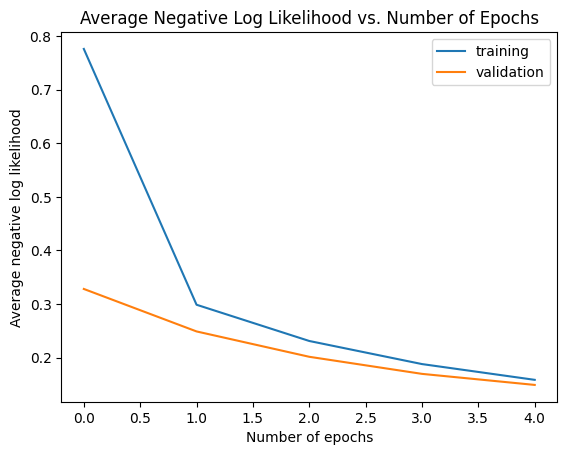

In [19]:
D1, D2 = 64, 32
W1 = np.random.uniform(high=-0.1, low=0.1, size=(D1, M+1))
W2 = np.random.uniform(high=-0.1, low=0.1, size=(D2, D1+1))
W3 = np.random.uniform(high=-0.1, low=0.1, size=(C, D2+1))
num_epochs = 5
lr = 0.001

print('Training your 2-layer neural net...')
nn2layer_output = nnModel.trainDLNN(X_train=X_train, 
                                 Y_train=onehot_Y_train, 
                                 X_val=X_val, 
                                 Y_val=onehot_Y_val, 
                                 W1=W1, 
                                 W2=W2, 
                                 W3=W3, 
                                 num_epochs=num_epochs, 
                                 lr=lr)

print('Plotting loss vs. epoch graphs...')
num_epochs_lst = [i for i in range(num_epochs)]
plot_losses(num_epochs=num_epochs_lst, 
            train_losses=nn2layer_output['train_losses'], 
            val_losses=nn2layer_output['val_losses'])

In [20]:
print('Making predictions...')
Y_hat_train_2 = nnModel.predictDouble(
    X=X_train, 
    W1=nn2layer_output['best_W1'], 
    W2=nn2layer_output['best_W2'], 
    W3=nn2layer_output['best_W3']
)
Y_hat_val_2 = nnModel.predictDouble(
    X=X_val, 
    W1=nn2layer_output['best_W1'], 
    W2=nn2layer_output['best_W2'], 
    W3=nn2layer_output['best_W3']
)
Y_hat_test_2 = nnModel.predictDouble(
    X=X_test, 
    W1=nn2layer_output['best_W1'], 
    W2=nn2layer_output['best_W2'], 
    W3=nn2layer_output['best_W3']
)

print('Getting accuracies...')
train_accuracy_2 = 1 - NN.CoreFunctions.errorRate(Y_train, Y_hat_train_2['labels'])
val_accuracy_2 = 1 - NN.CoreFunctions.errorRate(Y_val, Y_hat_val_2['labels'])
test_accuracy_2 = 1 - NN.CoreFunctions.errorRate(Y_test, Y_hat_test_2['labels'])

print('accuracy on train = %0.2f %%' % (100*train_accuracy_2))
print('accuracy on val = %0.2f %%' % (100*val_accuracy_2))
print('accuracy on test = %0.2f %%' % (100*test_accuracy_2))

Making predictions...
Getting accuracies...
accuracy on train = 95.68 %
accuracy on val = 95.91 %
accuracy on test = 95.48 %
Getting accuracies...
accuracy on train = 95.68 %
accuracy on val = 95.91 %
accuracy on test = 95.48 %


### Visualizing Predictions

C:\Users\aadip\AppData\Local\Temp\ipykernel_17572\2938001531.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(f"Pred: {LABEL_MAP[int(pred_label)]}", fontsize=8)


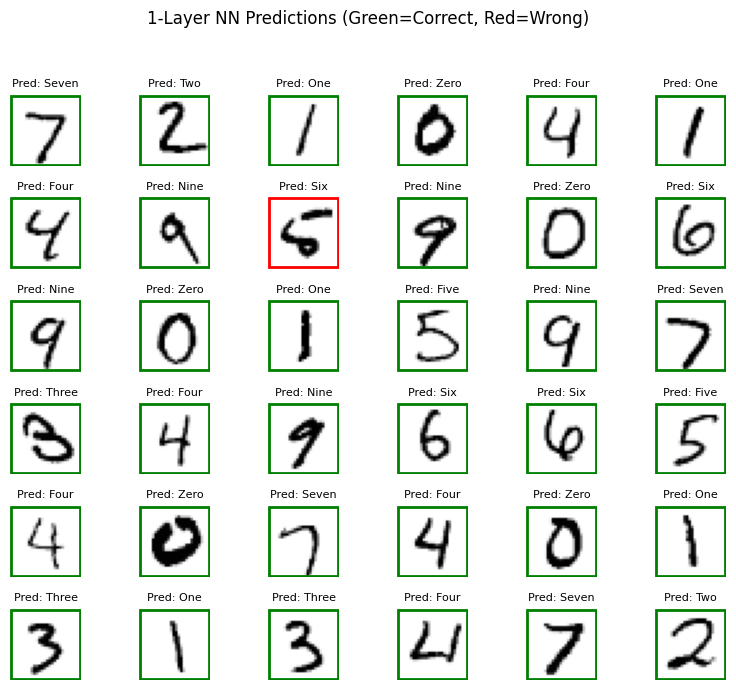

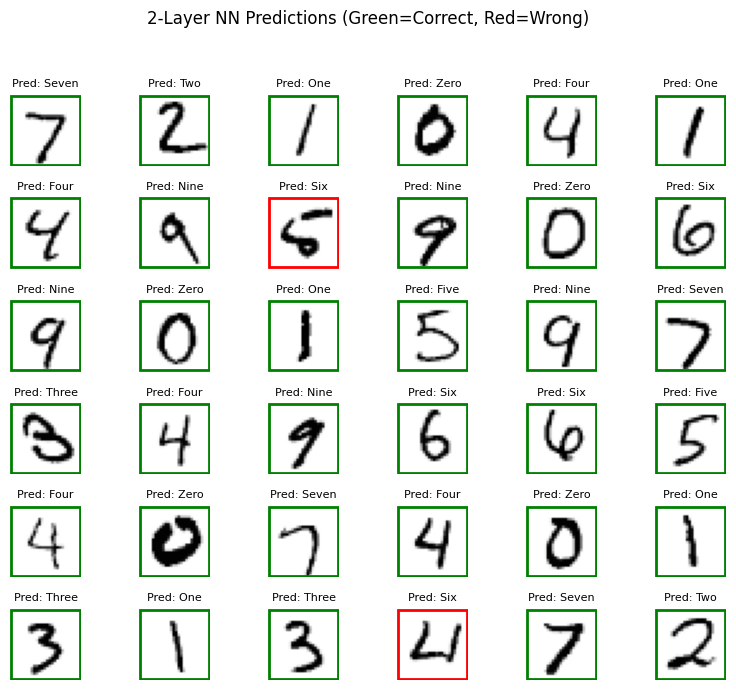

In [21]:
import matplotlib.patches as patches
def visualize_predictions(X, Y_true, Y_pred, LABEL_MAP, num_display=25, title_prefix="", fig_size=(8, 7)):
    plt.figure(figsize=fig_size)
    num_cells = int(np.ceil(np.sqrt(num_display)))
    for i in range(num_display):
        ax = plt.subplot(num_cells, num_cells, i + 1)
        image = X[i].reshape(28, 28)
        true_label = Y_true[i, 0] if Y_true.ndim == 2 else Y_true[i]
        pred_label = Y_pred[i][0] if Y_pred[i].ndim > 1 else Y_pred[i]
        correct = (true_label == pred_label)
        cmap = 'Greys'
        ax.imshow(image, cmap=cmap)
        ax.set_title(f"Pred: {LABEL_MAP[int(pred_label)]}", fontsize=8)
        
        color = 'green' if correct else 'red'
        rect = patches.Rectangle((0,0),27,27,linewidth=2,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
        ax.axis('off')
    plt.suptitle(title_prefix + " Predictions (Green=Correct, Red=Wrong)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

visualize_predictions(X_test, Y_test, Y_hat_test['labels'], LABEL_MAP, num_display=NUM_DISPLAY, title_prefix="1-Layer NN")

visualize_predictions(X_test, Y_test, Y_hat_test_2['labels'], LABEL_MAP, num_display=NUM_DISPLAY, title_prefix="2-Layer NN")